# Import Libraries

In [1]:
from pathlib import Path
from mrcnn.config import Config
from mrcnn import utils
import mrcnn.model as modellib
import mrcnn.model as DataGenerator
from mrcnn import visualize
from mrcnn.model import log
import pandas as pd
import os
import random
import cv2
import numpy as np
import ast
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt


In [2]:
import os
os.environ['CUDA_DEVICE_ORDER'] = 'PCI_BUS_ID'
os.environ['CUDA_VISIBLE_DEVICES'] = "0" #please put your GPU

# Global Variables

In [3]:
NUM_CATS = 14
IMAGE_SIZE = 512
selected_classes = list(i for i in range(14)) 
category_list = ['Aortic enlargement','Atelectasis','Calcification',
                'Cardiomegaly','Consolidation','ILD','Infiltration','Lung Opacity',
                'Nodule/Mass','Other lesion','Pleural effusion','Pleural thickening',
                'Pneumothorax','Pulmonary fibrosis']

resized_test_folder = "train/"

IMG_ROOT = 'train/'

# Load Data

In [4]:
## Load data
samples_df = pd.read_csv('train_512.csv')

## For testing
df = pd.read_csv("train_scaled_rev.01.csv")


# Load Data Functions and model weights

In [5]:
class DiagnosticConfig(Config):
    NAME = "Diagnostic"
    NUM_CLASSES = NUM_CATS + 1 # +1 for the background class
    
    GPU_COUNT = 1
    IMAGES_PER_GPU = 2 #That is the maximum with the memory available on kernels
    
    BACKBONE = 'resnet50'
    
    IMAGE_MIN_DIM = IMAGE_SIZE
    IMAGE_MAX_DIM = IMAGE_SIZE    
    IMAGE_RESIZE_MODE = 'none'

    POST_NMS_ROIS_TRAINING = 250
    POST_NMS_ROIS_INFERENCE = 150
    MAX_GROUNDTRUTH_INSTANCES = 5
    BACKBONE_STRIDES = [4, 8, 16, 32, 64]
    BACKBONESHAPE = (8, 16, 24, 32, 48)
    RPN_ANCHOR_SCALES = (8,16,24,32,48)
    ROI_POSITIVE_RATIO = 0.33
    DETECTION_MAX_INSTANCES = 300
    DETECTION_MIN_CONFIDENCE = 0.7    
    # STEPS_PER_EPOCH should be the number of instances 
    # divided by (GPU_COUNT*IMAGES_PER_GPU), and so should VALIDATION_STEPS;
    # however, due to the time limit, I set them so that this kernel can be run in 9 hours
    STEPS_PER_EPOCH = int(len(samples_df)*0.9/IMAGES_PER_GPU)
    VALIDATION_STEPS = len(samples_df)-int(len(samples_df)*0.9/IMAGES_PER_GPU)
    
config = DiagnosticConfig()
config.display()



Configurations:
BACKBONE                       resnet50
BACKBONESHAPE                  (8, 16, 24, 32, 48)
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     2
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        300
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 2
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  512
IMAGE_META_SIZE                27
IMAGE_MIN_DIM                  512
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              none
IMAGE_SHAPE                    [512 512   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL

In [6]:
## Model load weight 
class InferenceConfig(DiagnosticConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
    IMAGE_MIN_DIM = IMAGE_SIZE
    IMAGE_MAX_DIM = IMAGE_SIZE    
    IMAGE_RESIZE_MODE = 'none'
    DETECTION_MIN_CONFIDENCE = 0.8
    DETECTION_NMS_THRESHOLD = 0.5

inference_config = InferenceConfig()

model = modellib.MaskRCNN(mode='inference', 
                          config=inference_config,
                          model_dir="")

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [8]:
model.load_weights('logs/mask_rcnn_shapes_rev.01.h5', by_name=True)

In [9]:
def iou_coef(y_true, y_pred, smooth=1):
    try:
        intersection = sum(abs(y_true * y_pred))
        union = sum((y_true)+(y_pred))
        iou = np.mean((intersection + smooth) / (union + smooth))
    except:
        return 0
    return iou

In [10]:
# Function for getting testing mask
def get_test_mask(img_dimensions, x_min, y_min, x_max, y_max):
    img_height, img_width = img_dimensions
    img_mask = np.full((img_height,img_width),0)
#     img_mask[y_min:y_max,x_min:x_max] = 255
    img_mask[y_min:y_max,x_min:x_max] = 1
    
#     return img_mask.astype(np.float32)
    return img_mask.astype(np.int)

# Function for getting prediction mask
def get_predict_mask(img_dimensions, input_array):
    x_min, y_min, x_max, y_max = input_array
    img_height, img_width = img_dimensions
    img_mask = np.full((img_height,img_width),0)
#     img_mask[y_min:y_max,x_min:x_max] = 255
    img_mask[y_min:y_max,x_min:x_max] = 1
    
#     return img_mask.astype(np.float32)
    return img_mask.astype(np.int)

In [11]:
from skimage.measure import find_contours
from matplotlib.patches import Polygon


# Fix overlapping masks
def refine_masks(masks, rois):
    areas = np.sum(masks.reshape(-1, masks.shape[-1]), axis=0)
    mask_index = np.argsort(areas)
    union_mask = np.zeros(masks.shape[:-1], dtype=bool)
    for m in mask_index:
        masks[:, :, m] = np.logical_and(masks[:, :, m], np.logical_not(union_mask))
        union_mask = np.logical_or(masks[:, :, m], union_mask)
    for m in range(masks.shape[-1]):
        mask_pos = np.where(masks[:, :, m]==True)
        if np.any(mask_pos):
            y1, x1 = np.min(mask_pos, axis=1)
            y2, x2 = np.max(mask_pos, axis=1)
            rois[m, :] = [y1, x1, y2, x2]
    return masks, rois

def decode_rle(rle, height, width):
    s = rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(height*width, dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape((height, width)).T

def annotations_to_mask(annotations, height, width):
    if isinstance(annotations, list):
        # The annotation consists in a list of RLE codes
        mask = np.zeros((height, width, len(annotations)))
        for i, rle_code in enumerate(annotations):
            mask[:, :, i] = decode_rle(rle_code, height, width)
    else:
        error_message = "{} is expected to be a list or str but received {}".format(annotation, type(annotation))
        raise TypeError(error_message)
    return mask

def find_anomalies(dicom_image, display=False):

    image_dimensions = dicom_image.shape
    image_size = 512
    resized_img = cv2.resize(dicom_image, (image_size,image_size), interpolation = cv2.INTER_AREA)
    saved_filename = resized_test_folder+"temp_image.png"
    cv2.imwrite(saved_filename, resized_img) 
    img = cv2.imread(saved_filename)

    result = model.detect([img])
    r = result[0]
    
    if r['masks'].size > 0:
        masks = np.zeros((img.shape[0], img.shape[1], r['masks'].shape[-1]), dtype=np.uint8)
        for m in range(r['masks'].shape[-1]):
            masks[:, :, m] = cv2.resize(r['masks'][:, :, m].astype('uint8'), 
                                        (img.shape[1], img.shape[0]), interpolation=cv2.INTER_NEAREST)
        
        y_scale = image_dimensions[0]/IMAGE_SIZE
        x_scale = image_dimensions[1]/IMAGE_SIZE
        rois = (r['rois'] * [y_scale, x_scale, y_scale, x_scale]).astype(int)
        
        masks, rois = refine_masks(masks, rois)
    else:
        masks, rois = r['masks'], r['rois']
        
    if display:
        visualize.display_instances(img, rois, masks, r['class_ids'], 
                                    ['bg']+category_list, r['scores'],
                                    title="prediction", figsize=(12, 12))
    return rois, r['class_ids'], r['scores']

In [12]:
# Get image as numpy array
def load_image(name, path):
    img_path = path + name + '.png'
    img = cv2.imread(img_path)
    img = cv2.resize(img, (512, 512), interpolation = cv2.INTER_AREA)
    return img

# Plot numpy array
def plot_image(img):
    plt.imshow(img)
    plt.title(img.shape)
    
# Plot a grid of examples
def plot_grid(img_names, img_root, rows=5, cols=5):
    fig = plt.figure(figsize=(25,25))
    
    for i,name in enumerate(img_names):
        fig.add_subplot(rows,cols,i+1)
        img = load_image(name, img_root)
        plot_image(img)
        
    plt.show()
    

# Plot an example
def plot_example_image(img):
    _, ax = plt.subplots(1, figsize=(IMAGE_SIZE, IMAGE_SIZE))
    plt.imshow(img)
    plt.title(img.shape)
    height, width = (IMAGE_SIZE, IMAGE_SIZE)
    ax.set_ylim(height + 10, -10)
    ax.set_xlim(-10, width + 10)
    ax.axis('off')
    ax.set_title(title)
    
    plt.show()
    
    
def resize(org_size, new_size):
    return org_size/new_size
    

In [13]:
'''
Revised Plotters
'''

# draw all annotation bounding boxes on an image
def annotate_predicted_image(img, name, result):
    result = result
    for roi in range(len(result[0]['rois'])):
        draw_predicted_bounding_box(img, roi)
        
def draw_predicted_bounding_box(img, row):
    y_min, x_min, y_max, x_max = result[0]['rois'][row]
    
    class_id = int(result[0]['class_ids'][row])
    color = class_to_color(class_id-1)
    
    cv2.rectangle(img,(x_min,y_min),(x_max,y_max), color, 2)


# Plot a grid of examples
def plot_revised_grid(img_name, img_root, rows=5, cols=5):
    fig = plt.figure(figsize=(20,20))
    
    fig.add_subplot(2,2,0+1)
    img = load_image(img_name, img_root)
    annotate_image(img, name, df)
    plot_image(img)
    
    fig.add_subplot(2,2,1+1)
    img = load_image(img_name, img_root)
    annotate_predicted_image(img, name, result)
    plot_image(img)


In [14]:
def class_to_color(class_id):
    colors = [(255,0,0),(0,255,0),(0,0,255),(255,255,0),(255,0,255),(0,255,255),(255,100,100),
              (100,255,100),(100,100,255),(255,100,0),(255,0,100),(100,0,255),(100,100,255),(100,255,0),
              (100,255,100)]
    return colors[class_id]

# draw a single bounding box onto a numpy array image
def draw_bounding_box(img, annotation):
    if annotation.isnull().values.any():
        return
    
    x_min, y_min = int(annotation['x_min_scaled']), int(annotation['y_min_scaled'])
    x_max, y_max = int(annotation['x_max_scaled']), int(annotation['y_max_scaled'])
    
    class_id = int(annotation['class_id'])
    color = class_to_color(class_id)
    
    cv2.rectangle(img,(x_min,y_min),(x_max,y_max), color, 2)

# draw all annotation bounding boxes on an image
def annotate_image(img, name, all_annotations):
    annotations = all_annotations[all_annotations['image_id'] == name]
    for index, row in annotations.iterrows():
        draw_bounding_box(img, row)

# Model Prediction and Visualisation

In [15]:
def iou_evaluation(folder_name, img_name, data_type):
    
    # Declare Variables
    ground_truth = df.loc[df['image_id'] == img_name]['class_name']
    ground_truth = [items for items in ground_truth]
    
    ground_truth_undetected = set(ground_truth.copy())
#     print(ground_truth_undetected)
    ground_truth_detected = []
    
    
    # Resizing images
    dicom_image = cv2.imread(folder_name + img_name + data_type)
    image_dimensions = dicom_image.shape
    image_size = 512
    resized_img = cv2.resize(dicom_image, (image_size,image_size), interpolation = cv2.INTER_AREA)

    # Predicted result
    # Have to minus 1 due to difference in id mapping
    result = model.detect([resized_img])
    predicted_classes = [category_list[pred_class-1] for pred_class in result[0]['class_ids']]
    
    total_iou = 0
    num_iou = len(predicted_classes)
#     print(num_iou)

    # Calculate IoU
    for i in range (len(result[0]['rois'])):
        # Results number
        result_num = i

        # Masked test values derived from bounding boxes for 1st input
        test_mask_1 = get_test_mask((512,512), int(df.loc[df['image_id'] == img_name]['x_min_scaled'][result_num:result_num+1]), 
                 int(df.loc[df['image_id'] == img_name]['y_min_scaled'][result_num:result_num+1]), 
                 int(df.loc[df['image_id'] == img_name]['x_max_scaled'][result_num:result_num+1]), 
                 int(df.loc[df['image_id'] == img_name]['y_max_scaled'][result_num:result_num+1]))

        # Predict values derived from bounding boxes for 1st input
        predict_mask_1 = get_predict_mask((512,512), result[0]['rois'][result_num])

        # Calculating IoU
        result_iou = iou_coef(predict_mask_1, test_mask_1)
        total_iou += result_iou
        
    # Print evaluation
    '''
    if len(result[0]['class_ids']):
        for class_id in result[0]['class_ids']:
            class_name = category_list[class_id]
            if class_name not in ground_truth:
                ground_truth_undetected.append(class_id)
    '''
    
    if predicted_classes:
        for class_name in predicted_classes:
            if class_name not in ground_truth:
                pass
            else:
                ground_truth_detected.append(class_name)
                ground_truth_undetected.discard(str(class_name))
                
    # To prevent division by 0 error
    if num_iou > 0:
        overall_iou = float(total_iou)/int(num_iou)
    else:
        overall_iou = 0
    
    
    # Use a set for calculating the  % as there may be repeated classes
    print('The predicted classes were: ', set(predicted_classes))
    print('The ground_truth classes were: ', set(ground_truth))
    print('The undetected ground truth were: ', ground_truth_undetected)
    print('The detected ground truth were: ', ground_truth_detected)
    gt_l = len(set(ground_truth))
    gt_u = len(set(ground_truth_undetected))
    print('% of classes identified correctly: ', ((gt_l - gt_u) / gt_l))
            
    print(f'Overall IOU accuracy of area detected irrespective of classes is {overall_iou}\n')


In [16]:
'''
Testing variables
'''
folder_name = 'train/'
img_name = '1f5a95707791ca66198f87bf0d11e89e'
data_type = '.png'

name = img_name
img = load_image(name, IMG_ROOT)
annotate_image(img, name, df)

dicom_image = cv2.imread(folder_name + img_name + data_type)
image_dimensions = dicom_image.shape
image_size = 512
resized_img = cv2.resize(dicom_image, (image_size,image_size), interpolation = cv2.INTER_AREA)

In [17]:
samples_df.loc[samples_df['image_id'] == img_name]

,Unnamed: 0,image_id,CategoryId,EncodedPixels,Rad_id,Height,Width
3291,3291,1f5a95707791ca66198f87bf0d11e89e,"[0, 3]",['120914 82 121426 82 121938 82 122450 82 1229...,R9,512,512
3292,3292,1f5a95707791ca66198f87bf0d11e89e,"[0, 3]",['121937 59 122449 59 122961 59 123473 59 1239...,R10,512,512
3293,3293,1f5a95707791ca66198f87bf0d11e89e,"[0, 3]",['129616 57 130128 57 130640 57 131152 57 1316...,R8,512,512


In [18]:
df.loc[df['image_id'] == img_name]

,image_id,dim0,dim1,class_name,class_id,rad_id,x_min,y_min,x_max,y_max,x_dim,y_dim,x_min_scaled,x_max_scaled,y_min_scaled,y_max_scaled
17298,1f5a95707791ca66198f87bf0d11e89e,2880,2304,Aortic enlargement,0,R9,1065.0,457.0,1377.0,919.0,410,512,236.666667,306.000000,81.244444,163.377778
17299,1f5a95707791ca66198f87bf0d11e89e,2880,2304,Aortic enlargement,0,R10,1071.0,452.0,1385.0,786.0,410,512,238.000000,307.777778,80.355556,139.733333
17300,1f5a95707791ca66198f87bf0d11e89e,2880,2304,Cardiomegaly,3,R10,731.0,958.0,1741.0,1253.0,410,512,162.444444,386.888889,170.311111,222.755556
17301,1f5a95707791ca66198f87bf0d11e89e,2880,2304,Aortic enlargement,0,R8,1140.0,447.0,1384.0,768.0,410,512,253.333333,307.555556,79.466667,136.533333
17302,1f5a95707791ca66198f87bf0d11e89e,2880,2304,Cardiomegaly,3,R8,774.0,1009.0,1762.0,1308.0,410,512,172.000000,391.555556,179.377778,232.533333
17303,1f5a95707791ca66198f87bf0d11e89e,2880,2304,Cardiomegaly,3,R9,723.0,1014.0,1779.0,1272.0,410,512,160.666667,395.333333,180.266667,226.133333


The predicted classes were:  {'Pleural effusion', 'Cardiomegaly', 'Aortic enlargement'}
The ground_truth classes were:  {'Cardiomegaly', 'Aortic enlargement'}
The undetected ground truth were:  set()
The detected ground truth were:  ['Cardiomegaly', 'Aortic enlargement']
% of classes identified correctly:  1.0
Overall IOU accuracy of area detected irrespective of classes is 0.6204215396141968

None


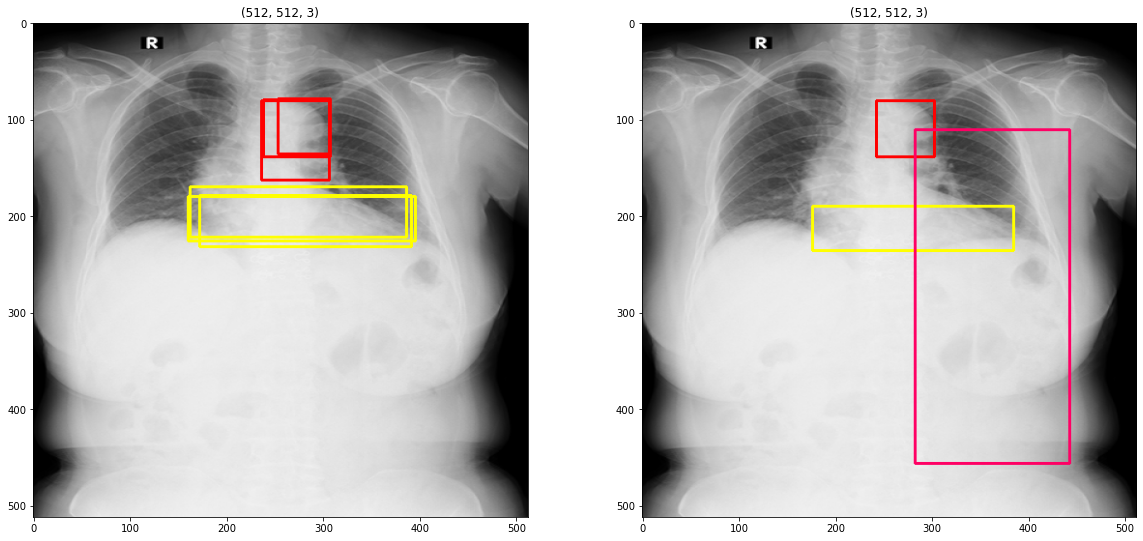

In [19]:
'''
Evaluation
'''

result = model.detect([resized_img])

plot_revised_grid(img_name, folder_name)

print(iou_evaluation(folder_name, img_name, data_type))

# Another Example

In [20]:
'''
Testing Variables
'''
folder_name = 'train/'
img_name = '5ed9dc88e3fc76c9cb834ed274994ebf'
data_type = '.png'

name = img_name
img = load_image(name, IMG_ROOT)
annotate_image(img, name, df)

dicom_image = cv2.imread(folder_name + img_name + data_type)
image_dimensions = dicom_image.shape
image_size = 512
resized_img = cv2.resize(dicom_image, (image_size,image_size), interpolation = cv2.INTER_AREA)

The predicted classes were:  {'Cardiomegaly', 'Aortic enlargement'}
The ground_truth classes were:  {'Cardiomegaly', 'Aortic enlargement'}
The undetected ground truth were:  set()
The detected ground truth were:  ['Aortic enlargement', 'Cardiomegaly']
% of classes identified correctly:  1.0
Overall IOU accuracy of area detected irrespective of classes is 0.7276943845538183

None


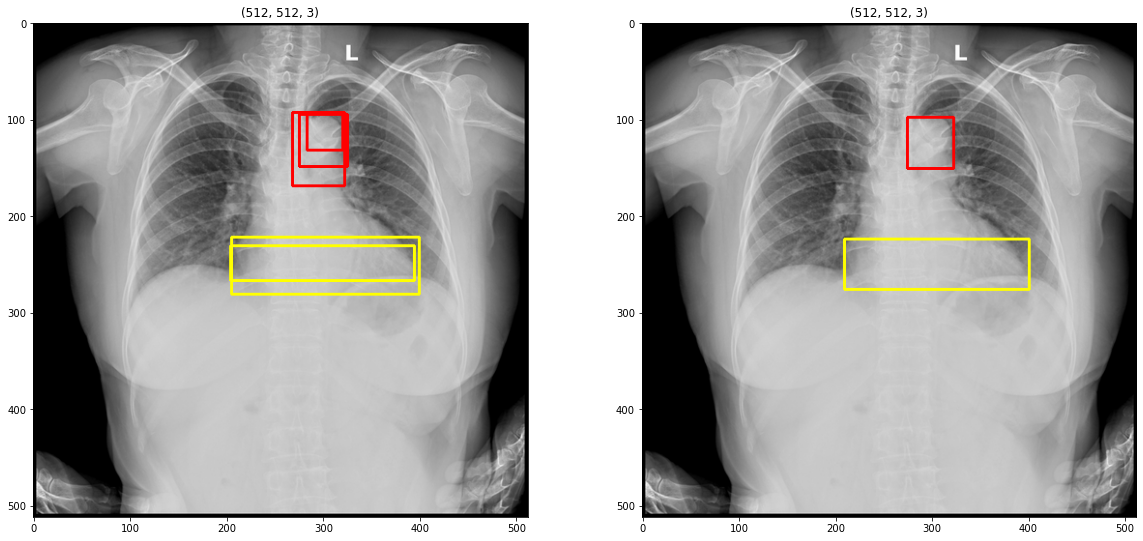

In [21]:
'''
Evaluation
'''

result = model.detect([resized_img])

plot_revised_grid(img_name, folder_name)

print(iou_evaluation(folder_name, img_name, data_type))

# Yet another example

In [22]:
'''
Testing Variables
'''

folder_name = 'train/'
img_name = 'e8acde7bd3c521671dae97d0a75cdde0'
data_type = '.png'

name = img_name
img = load_image(name, IMG_ROOT)
annotate_image(img, name, df)

dicom_image = cv2.imread(folder_name + img_name + data_type)
image_dimensions = dicom_image.shape
image_size = 512
resized_img = cv2.resize(dicom_image, (image_size,image_size), interpolation = cv2.INTER_AREA)

The predicted classes were:  {'Cardiomegaly', 'Aortic enlargement'}
The ground_truth classes were:  {'Calcification', 'Pulmonary fibrosis', 'Cardiomegaly', 'Aortic enlargement', 'Other lesion'}
The undetected ground truth were:  {'Calcification', 'Pulmonary fibrosis', 'Other lesion'}
The detected ground truth were:  ['Aortic enlargement', 'Cardiomegaly']
% of classes identified correctly:  0.4
Overall IOU accuracy of area detected irrespective of classes is 0.6819616196818042

None


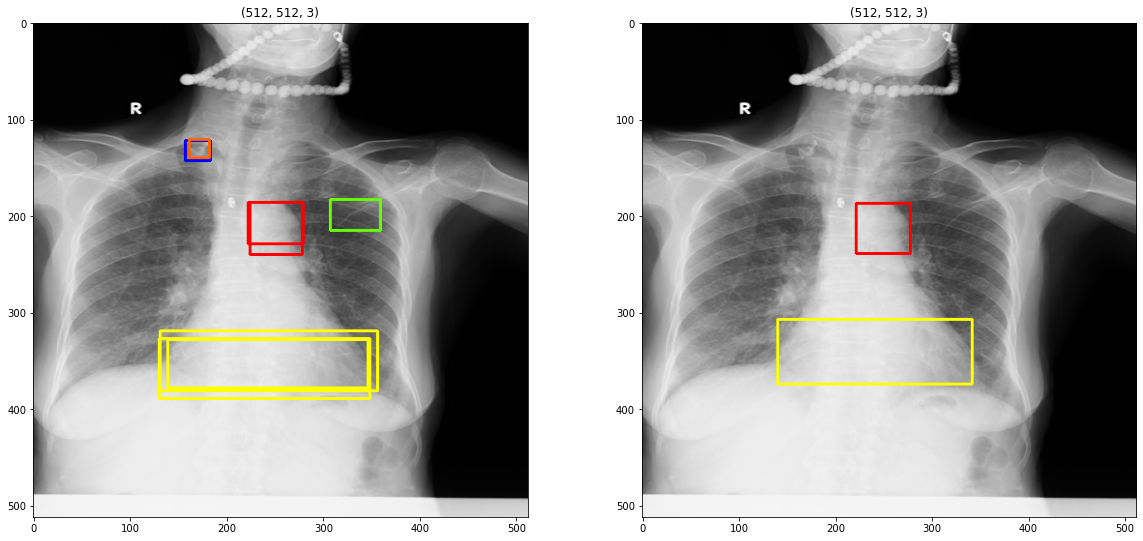

In [23]:
'''
Evaluation
'''

result = model.detect([resized_img])

plot_revised_grid(img_name, folder_name)

print(iou_evaluation(folder_name, img_name, data_type))

# Last Example

In [24]:
'''
Testing Variables
'''

folder_name = 'train/'
img_name = '1be94a4e06067c5ecd66488cad60a087'
data_type = '.png'

name = img_name
img = load_image(name, IMG_ROOT)
annotate_image(img, name, df)

dicom_image = cv2.imread(folder_name + img_name + data_type)
image_dimensions = dicom_image.shape
image_size = 512
resized_img = cv2.resize(dicom_image, (image_size,image_size), interpolation = cv2.INTER_AREA)

The predicted classes were:  {'Cardiomegaly', 'Aortic enlargement'}
The ground_truth classes were:  {'Lung Opacity', 'Cardiomegaly', 'Aortic enlargement'}
The undetected ground truth were:  {'Lung Opacity'}
The detected ground truth were:  ['Cardiomegaly', 'Aortic enlargement']
% of classes identified correctly:  0.6666666666666666
Overall IOU accuracy of area detected irrespective of classes is 0.6834731406767252

None


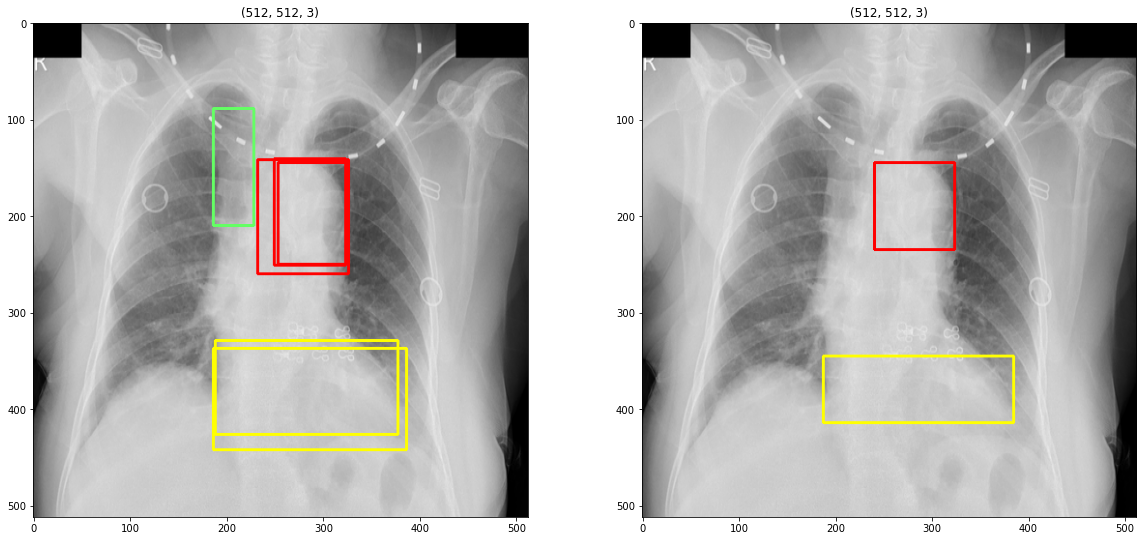

In [25]:
'''
Evaluation
'''

result = model.detect([resized_img])

plot_revised_grid(img_name, folder_name)

print(iou_evaluation(folder_name, img_name, data_type))

In [26]:
'''
Testing Variables
'''

folder_name = 'train/'
img_name = 'f4c97bfedbc71ab64cf312ea2962971e'
data_type = '.png'

name = img_name
img = load_image(name, IMG_ROOT)
annotate_image(img, name, df)

dicom_image = cv2.imread(folder_name + img_name + data_type)
image_dimensions = dicom_image.shape
image_size = 512
resized_img = cv2.resize(dicom_image, (image_size,image_size), interpolation = cv2.INTER_AREA)

The predicted classes were:  {'Cardiomegaly', 'Aortic enlargement'}
The ground_truth classes were:  {'Lung Opacity', 'Cardiomegaly', 'Aortic enlargement', 'Pleural effusion', 'Pleural thickening'}
The undetected ground truth were:  {'Lung Opacity', 'Pleural effusion', 'Pleural thickening'}
The detected ground truth were:  ['Cardiomegaly', 'Aortic enlargement']
% of classes identified correctly:  0.4
Overall IOU accuracy of area detected irrespective of classes is 0.6152475370993508

None


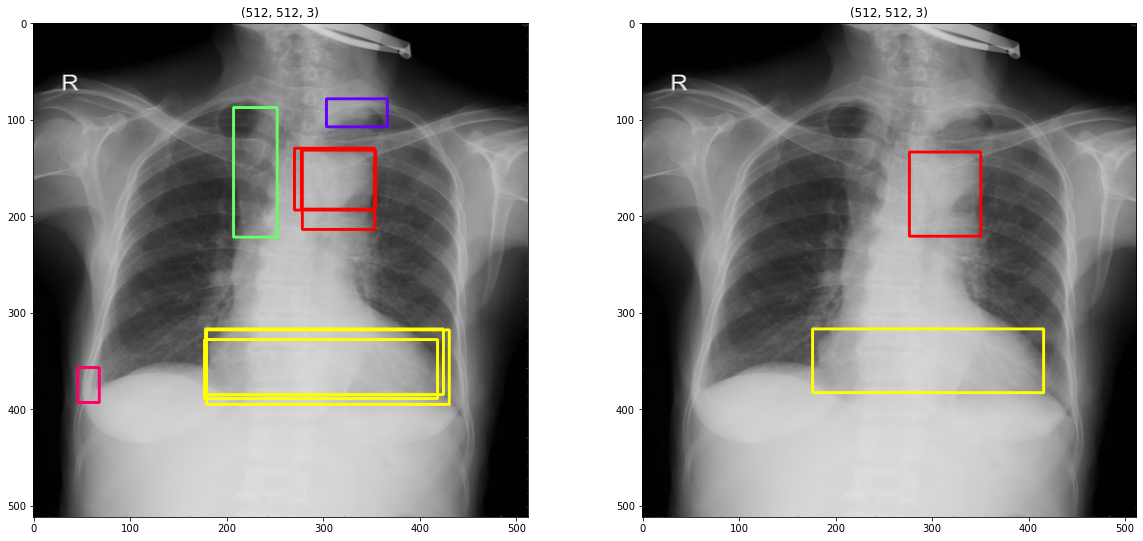

In [27]:
'''
Evaluation
'''

result = model.detect([resized_img])

plot_revised_grid(img_name, folder_name)

print(iou_evaluation(folder_name, img_name, data_type))